# Example analysis pipeline

## Simple comparison of neural activity during stimulus condition on/off 


Load in relevant local application modules:

In [1]:
import sys
import matplotlib.pyplot as plt

import os
import sys
import numpy as np
import random
from random import uniform
import copy

from types import SimpleNamespace
import inflect

# Local application imports 
from database.db_setup import *
import preprocessing.data_preprocessing.binning as binning
import preprocessing.data_preprocessing.create_vectors_from_time_points as create
import annotation.stimulus_driven_annotation.movies.annotation_utils as utils

Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306


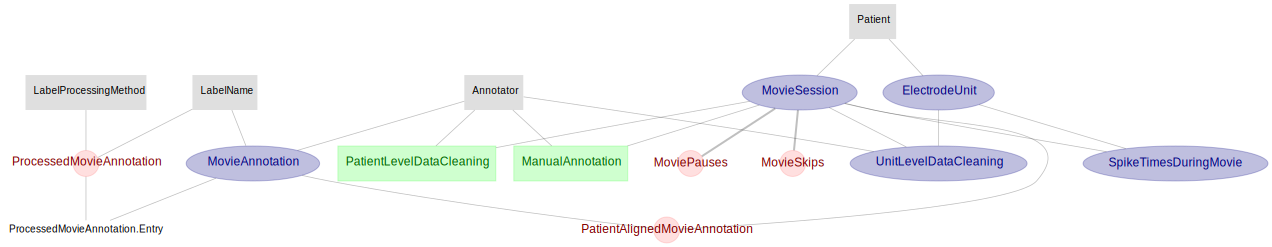

In [2]:
erd = dj.ERD(dhv_schema)
erd

In [56]:
LabelProcessingMethod.drop()
LabelName.drop()
Annotator.drop()
Patient.drop()

`db_deploy_mock`.`#label_processing_method` (2 tuples)
`db_deploy_mock`.`__processed_movie_annotation` (0 tuples)
`db_deploy_mock`.`__processed_movie_annotation__entry` (0 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.
`db_deploy_mock`.`#label_name` (3 tuples)
`db_deploy_mock`.`_movie_annotation` (3 tuples)
`db_deploy_mock`.`__patient_aligned_movie_annotation` (9 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.
`db_deploy_mock`.`#annotator` (2 tuples)
`db_deploy_mock`.`patient_level_data_cleaning` (0 tuples)
`db_deploy_mock`.`manual_annotation` (0 tuples)
`db_deploy_mock`.`_unit_level_data_cleaning` (0 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.
`db_deploy_mock`.`#patient` (3 tuples)
`db_deploy_mock`.`_movie_session` (3 tuples)
`db_deploy_mock`.`__movie_skips` (3 tuples)
`db_deploy_mock`.`__movie_pauses` (3 tuples)
`db_deploy_mock`.`_electrode_unit` (268 tuples)
`db_deploy_mock`.`_spike_times_during_movie` (268 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


Set parameters:

In [14]:
patient_id = 2
session_nr = 1
unit_nr = 1
bin_size = 1000

Get activity from the database, set binning parameters, and bin: 

In [15]:
spike_times = get_spiking_activity(patient_id, session_nr, unit_nr)
spike_times = np.sort(spike_times) / 1000

exclude_pauses = False
output_edges = True

binned_spikes, edges = binning.bin_spikes(patient_id, session_nr, spike_times, bin_size, exclude_pauses, output_edges) 

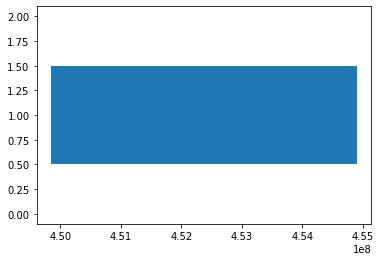

In [9]:
plt.eventplot(spike_times)

In [54]:
begin = 349760058000
stop =  355900349000

(stop - begin) / 1000 / 1000 / 60

102.33818333333333

In [18]:
spike_times[-1]

355900079.20821905

In [17]:
edges[-1]

363076582.2035

In [44]:
361921652298.25 / 1000

361921652.29825

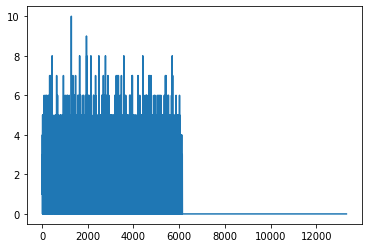

In [16]:
plt.plot(binned_spikes)

In [7]:
edges

array([4.49860098e+08, 4.49861098e+08, 4.49862098e+08, ...,
       4.59177825e+08, 4.59178825e+08, 4.59179825e+08])

In [11]:
PatientAlignedMovieAnnotation()

annotator_id unique ID for each annotator,label_name label name,annotation_date date of annotation,session_nr session ID,patient_id patient ID,label_in_patient_time label matched to patient time (pts),values list of values that represent label,start_times list of start times of label segments in neural recording time,stop_times list of stop times of label segments in neural recording time,additionl_information
p1,character1,2019-12-12,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character1,2019-12-12,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character1,2019-12-12,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character2,2019-10-10,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character2,2019-10-10,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character2,2019-10-10,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,


In [17]:
label_name = "location1"
annotation_date = "2020-01-01"
annotator_id = "p1"

pat_aligned_label = get_patient_aligned_annotations(patient_id, label_name, annotator_id, annotation_date)

In [18]:
pat_aligned_label

(array([0]), array([449860.09750073]), array([458282.33527466]))

In [31]:
rec = get_neural_rectime_of_patient(3, session_nr)

In [32]:
(rec[-1] - rec[0]) / 1000 / 1000 / 60

168.20430335833333

In [41]:
np.max(rec)

361921652298.25

In [62]:
get_info_continuous_watch_segments(patient_id, session_nr)

(array([0, 1, 2, 3]),
 array([4.49861247e+08, 4.73750484e+08, 5.52512790e+08, 5.61540968e+08]),
 array([4.73749294e+08, 5.52511600e+08, 5.61539779e+08, 5.99368481e+08]))

In [63]:
get_start_stop_times_pauses(patient_id, session_nr)

(array([506049.53045211, 542000.52297208, 550610.11469553, 564309.35611276,
        587416.12386267]),
 array([506051.9133717 , 542002.90211572, 550612.49586211, 564311.73961107,
        587418.51156834]))

In [22]:
dts = get_dts_of_patient(patient_id, session_nr)
dts = dts /  1000

Note: Divide the patient dts vector by 1000 to get milliseconds


In [23]:
dts[0]

1590528227648.514

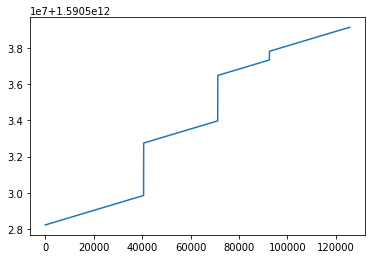

In [24]:
plt.plot(dts)

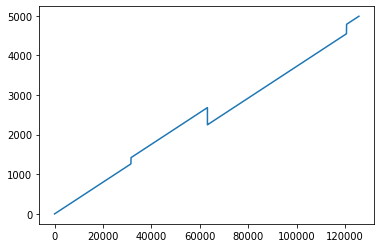

In [26]:
pts = get_pts_of_patient(patient_id, session_nr)

plt.plot(pts)

Using edges outputted above, generate a vector representing when a feature was presented during the stimulus:  

In [43]:
PatientAlignedMovieAnnotation()

annotator_id unique ID for each annotator,label_name label name,annotation_date date of annotation,session_nr session ID,patient_id patient ID,label_in_patient_time label matched to patient time (pts),values list of values that represent label,start_times list of start times of label segments in neural recording time,stop_times list of stop times of label segments in neural recording time,additionl_information
p1,character1,2019-12-12,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character1,2019-12-12,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character1,2019-12-12,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,


In [45]:
label_name = "character1"
annotator_id = "p1"
annotation_date = "2019-12-12"

values, starts, stops = get_patient_aligned_annotations(patient_id, label_name, annotator_id, annotation_date)

In [39]:
values, starts, stops = (PatientAlignedMovieAnnotation() & "label_name='{}'".format(label_name) & "annotator_id='{}'".format(annotator_id) & "annotation_date='{}'".format(annotation_date) &  "patient_id='{}'".format(patient_id)).fetch("values", "start_times", "stop_times")

In [55]:
original_label = get_original_movie_label(label_name, annotation_date, annotator_id)
pts_vec = get_pts_of_patient(patient_id, session_nr)

patient_aligned_label = helpers.match_label_to_patient_pts_time(default_label=original_label[0], patient_pts=pts_vec)
neural_rec_time = get_neural_rectime_of_patient(entry_key_movie_session[0]['patient_id'], entry_key_movie_session[0]['session_nr'])
values, starts, stops = create_vectors_from_time_points.get_start_stop_times_from_label(neural_rec_time, patient_aligned_label)

IndexError: invalid index to scalar variable.

In [46]:
starts

array([3.49760106e+08])

In [47]:
stops

array([3.63076582e+08])

In [48]:
values

array([0])

In [49]:
character1_binned = create.create_vector_from_start_stop_times_reference(edges, values, starts, stops)

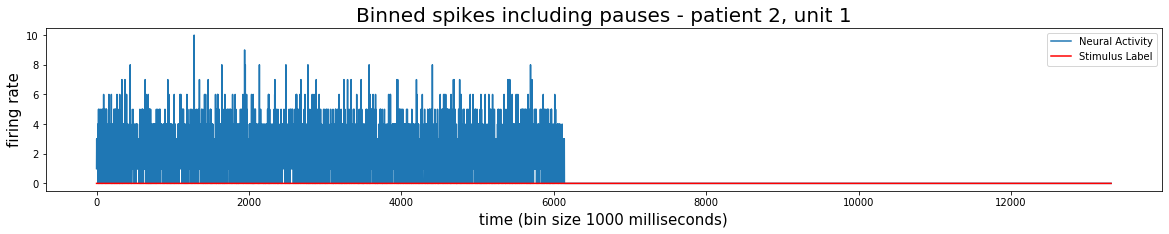

In [50]:
fig = plt.figure(figsize=(20,3))
plt.plot(binned_spikes, label="Neural Activity")
plt.plot(character1_binned, color="r", label="Stimulus Label")
if exclude_pauses:
    plt.title("Binned spikes excluding pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
else:
    plt.title("Binned spikes including pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
plt.xlabel("time (bin size {} milliseconds)".format(bin_size), fontsize=15)
plt.ylabel("firing rate", fontsize=15)

plt.legend()

plt.show()

Split activity into groups corresponding to the stimulus values, 

* One: Stimulus-on condition 
* Zero: Stimulus-off condition

In [65]:
tom_splits = utils.split_activity_by_value(binned_spikes, tom_binned)
tom_activity = SimpleNamespace(**tom_splits)

In [66]:
print(tom_activity.zero)
print(tom_activity.one)

print(len(tom_activity.zero) + len(tom_activity.one))
print(len(tom_binned))

[0 1 1 ... 0 0 0]
[4 1 2 ... 0 1 0]
4804
4804
